# Guide for data_processing.py file



## Importing required libraries

In [1]:
%matplotlib inline


import sys
from scipy import signal
import pydub as dub
import matplotlib


import os
import shutil
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display

import utils
import data_processing as datap

plt.rcParams['figure.figsize'] = (17, 5)

In [35]:
# Creating audio segment from audio file

def audio_loader(audio_file):
# Gets input audio_file location and outputs attributes of that audio file
    audio_name, format_type = audio_file.split(".")
    audio = dub.AudioSegment.from_file(audio_file, format=format_type)
    channel_count = audio.channels
    # Choosing one of the channels
    channels = audio.split_to_mono()
    audio = channels[0]
    
    fs = audio.frame_rate                  # sampling frequency
    num_frame = audio.frame_count()        # number of samples
    time = np.arange(num_frame) / fs        # timevector of length num_frame
    total_dur = num_frame / fs              # total duration of audio
    samples = audio.get_array_of_samples() # getting samples from audio
    max_amp = audio.max_possible_amplitude # maximum amplitude in samples
    data = np.divide(samples, max_amp)       # normalizing

    return data, fs

def windowing(a_win_ms, h_len_ms, fs):
#Gets input analysis window size and hop_size in terms of ms and calculates sample lengths along with overlap in samples

    a_len = np.ceil( fs * a_win_ms /1000 ) # ms to number of samples
    h_len = np.ceil( fs * h_len_ms /1000 )
    overlap = a_len - h_len # in samples

    return a_len, h_len, overlap

def mag_spec(data, a_len, overlap, fs):
    #gets normalized audio samples, frame length, and overlap length in samples as inputs to calculate magnitude spectogram
    f, t, stft = signal.stft(data, fs, nperseg = a_len, noverlap = overlap, nfft = 8192)
    stft_mag = np.abs(stft) / np.max(np.abs(stft)) # Magnitude spectrogram
    stft_mag_dB = 20*np.log10(stft_mag)
    
    return f, t, stft_mag, stft_mag_dB

## Importing music files and metadata files

In [6]:
# Load metadata and features.
tracks = utils.load('data/fma_metadata/tracks.csv')
genres = utils.load('data/fma_metadata/genres.csv')
features = utils.load('data/fma_metadata/features.csv')
echonest = utils.load('data/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

print("shape of tracks.csv file is :", tracks.shape)
print("shape of genres.csv file is :", genres.shape)
print("shape of features.csv file is :", features.shape)
print("shape of echonest.csv file is :", echonest.shape)



shape of tracks.csv file is : (106574, 52)
shape of genres.csv file is : (163, 4)
shape of features.csv file is : (106574, 518)
shape of echonest.csv file is : (13129, 249)


## 1 Metadata

The metadata table, a CSV file in the `fma_metadata.zip` archive, is composed of many colums:
1. The index is the ID of the song, taken from the website, used as the name of the audio file.
2. Per-track, per-album and per-artist metadata from the Free Music Archive website.
3. Two columns to indicate the subset (small, medium, large) and the split (training, validation, test).

In [7]:
print("-----dtypes of tracks.csv-----")
print(tracks.dtypes)
print("-----dtypes of genres.csv-----")
print(genres.dtypes)
print("-----dtypes of features.csv-----")
print(features.dtypes)
print("-----dtypes of echonest.csv-----")
print(echonest.dtypes)

-----dtypes of tracks.csv-----
album   comments                      int64
        date_created         datetime64[ns]
        date_released        datetime64[ns]
        engineer                     object
        favorites                     int64
        id                            int64
        information                category
        listens                       int64
        producer                     object
        tags                         object
        title                        object
        tracks                        int64
        type                       category
artist  active_year_begin    datetime64[ns]
        active_year_end      datetime64[ns]
        associated_labels            object
        bio                        category
        comments                      int64
        date_created         datetime64[ns]
        favorites                     int64
        id                            int64
        latitude                    float64
 

## 2 Splitting Example

In this part we call splitter function to split the given genres according to tracks dataframe artist ordering

In [8]:
chosen_genres = ['Hip-Hop', 'Pop', 'Rock', 'Folk', 'Experimental', 'Electronic', 'Classical', 'Old-Time / Historic' ]

In [11]:

train_perc = 60
validation_perc = 20
test_perc = 20
datap.splitter(train_perc, validation_perc, test_perc ,chosen_genres, tracks)

Distributing 300 tracks of Hip-Hop genre to training folder...
Folder 'train' created for genre 'Hip-Hop'
Distributing 100 tracks of Hip-Hop genre to validation folder...
Folder 'validation' created for genre 'Hip-Hop'
Distributing 100 tracks of Hip-Hop genre to test folder...
Folder 'test' created for genre 'Hip-Hop'
Distributing 300 tracks of Pop genre to training folder...
Folder 'train' created for genre 'Pop'
Distributing 100 tracks of Pop genre to validation folder...
Folder 'validation' created for genre 'Pop'
Distributing 100 tracks of Pop genre to test folder...
Folder 'test' created for genre 'Pop'
Distributing 300 tracks of Rock genre to training folder...
Folder 'train' created for genre 'Rock'
Distributing 100 tracks of Rock genre to validation folder...
Folder 'validation' created for genre 'Rock'
Distributing 100 tracks of Rock genre to test folder...
Folder 'test' created for genre 'Rock'
Distributing 300 tracks of Folk genre to training folder...
Folder 'train' created

## 3 Resetting Example

With this function, we reset the files and move them back to genres before using different values of splits

In [10]:
datap.data_reset(chosen_genres)

Resetting training data of Hip-Hop genre
Resetting validation data of Hip-Hop genre
Resetting test data of Hip-Hop genre
Resetting training data of Pop genre
Resetting validation data of Pop genre
Resetting test data of Pop genre
Resetting training data of Rock genre
Resetting validation data of Rock genre
Resetting test data of Rock genre
Resetting training data of Folk genre
Resetting validation data of Folk genre
Resetting test data of Folk genre
Resetting training data of Experimental genre
Resetting validation data of Experimental genre
Resetting test data of Experimental genre
Resetting training data of Electronic genre
Resetting validation data of Electronic genre
Resetting test data of Electronic genre
Resetting training data of Classical genre
Resetting validation data of Classical genre
Resetting test data of Classical genre
Resetting training data of Old-Time / Historic genre
Resetting validation data of Old-Time / Historic genre
Resetting test data of Old-Time / Historic ge

### Note: After splitting, you have to reset the data in order to split with different percentages

## 4 Checking statistics

Let's check some statistics and compare these data. First, let's split the data again

In [23]:
datap.splitter(train_perc, validation_perc, test_perc ,chosen_genres, tracks)

Distributing 400 tracks of Hip-Hop genre to training folder...
Folder 'train' created for genre 'Hip-Hop'
Distributing 50 tracks of Hip-Hop genre to validation folder...
Folder 'validation' created for genre 'Hip-Hop'
Distributing 50 tracks of Hip-Hop genre to test folder...
Folder 'test' created for genre 'Hip-Hop'
Distributing 400 tracks of Pop genre to training folder...
Folder 'train' created for genre 'Pop'
Distributing 50 tracks of Pop genre to validation folder...
Folder 'validation' created for genre 'Pop'
Distributing 50 tracks of Pop genre to test folder...
Folder 'test' created for genre 'Pop'
Distributing 400 tracks of Rock genre to training folder...
Folder 'train' created for genre 'Rock'
Distributing 50 tracks of Rock genre to validation folder...
Folder 'validation' created for genre 'Rock'
Distributing 50 tracks of Rock genre to test folder...
Folder 'test' created for genre 'Rock'
Distributing 400 tracks of Folk genre to training folder...
Folder 'train' created for g

In [12]:
path_train = "datasets/Rock/train"
path_val = "datasets/Rock/validation"
path_test = "datasets/Rock/test"

rock_train_tracks = np.array(os.listdir(path_train))
rock_val_tracks = np.array(os.listdir(path_val))
rock_train_test = np.array(os.listdir(path_test))

print("---Statistics of Rock Training Tracks---")
datap.show_statistics(rock_train_tracks, tracks)
print("---Statistics of Rock Validation Tracks---")
datap.show_statistics(rock_val_tracks, tracks)
print("---Statistics of Rock Test Tracks---")
datap.show_statistics(rock_train_test, tracks)

print("---Artist comparison of Training and Validation Data---")
datap.common_artists(rock_train_tracks,rock_val_tracks,tracks)
print("---Artist comparison of Training and Test Data---")
datap.common_artists(rock_train_tracks,rock_train_test,tracks)








---Statistics of Rock Training Tracks---
+++ The data contains: 300 tracks
+++ The genre is:  ['Rock']
+++ The data contains 65 artists 
+++ The data contains 79 albums
---Statistics of Rock Validation Tracks---
+++ The data contains: 100 tracks
+++ The genre is:  ['Rock']
+++ The data contains 18 artists 
+++ The data contains 23 albums
---Statistics of Rock Test Tracks---
+++ The data contains: 100 tracks
+++ The genre is:  ['Rock']
+++ The data contains 28 artists 
+++ The data contains 34 albums
---Artist comparison of Training and Validation Data---
+++ The first dataset contains 65 artists 
+++ The second dataset contains 18 artists 
+++ The datasets have 1 common artists
---Artist comparison of Training and Test Data---
+++ The first dataset contains 65 artists 
+++ The second dataset contains 28 artists 
+++ The datasets have 0 common artists


In [32]:
print(path_train + "/" + rock_train_tracks[1])
data, fs = audio_loader(path_train + "/" + rock_train_tracks[0])
print(fs)

a_win_ms = 46
h_len_ms = 23

a_len, h_len, overlap = windowing(a_win_ms, h_len_ms, fs)    

f, t, stft_mag, stft_mag_dB = mag_spec(data, a_len, overlap, fs)



datasets/Rock/train/008208.mp3
audio has channels of  2
44100


In [33]:
print(t[-1])

29.989682539682537


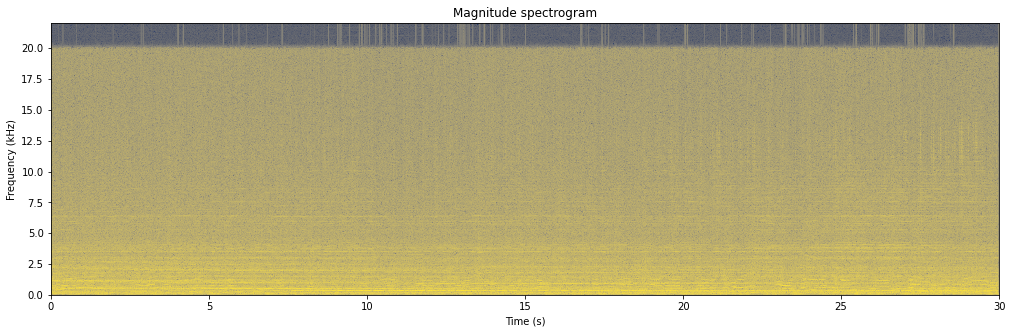

(4097, 1304)


In [34]:
fig, ax = plt.subplots()

plt.pcolormesh(t , f /1000, stft_mag_dB, shading='auto', cmap='cividis')
ax.set_ylabel('Frequency (kHz)')
ax.set_xlabel('Time (s)')
ax.set_title('Magnitude spectrogram')
#ax.set_ylim([0, 5])

plt.show()
print(stft_mag.shape)

In [7]:
for genre in chosen_genres:
    if genre == 'Old-Time / Historic':
        folder_name = "Old-Time - Historic"
    else:
        folder_name = genre
    
    path_train = "datasets/" + folder_name + "/train"
    train_tracks = np.array(os.listdir(path_train))
    print("---Statistics of " +genre +" Training Tracks---")
    datap.show_statistics(train_tracks, tracks)
    


---Statistics of Hip-Hop Training Tracks---
+++ The data contains: 500 tracks
+++ The genre is:  ['Hip-Hop']
+++ The data contains 43 artists 
+++ The data contains 95 albums
---Statistics of Pop Training Tracks---
+++ The data contains: 500 tracks
+++ The genre is:  ['Pop']
+++ The data contains 140 artists 
+++ The data contains 131 albums
---Statistics of Rock Training Tracks---
+++ The data contains: 500 tracks
+++ The genre is:  ['Rock']
+++ The data contains 109 artists 
+++ The data contains 131 albums
---Statistics of Folk Training Tracks---
+++ The data contains: 500 tracks
+++ The genre is:  ['Folk']
+++ The data contains 77 artists 
+++ The data contains 104 albums
---Statistics of Experimental Training Tracks---
+++ The data contains: 500 tracks
+++ The genre is:  ['Experimental']
+++ The data contains 206 artists 
+++ The data contains 179 albums
---Statistics of Electronic Training Tracks---
+++ The data contains: 500 tracks
+++ The genre is:  ['Electronic']
+++ The data 

In [6]:
for genre in chosen_genres:
    if genre == 'Old-Time / Historic':
        folder_name = "Old-Time - Historic"
    else:
        folder_name = genre
    
    path_train = "datasets/" + folder_name + "/train"
    path_validation = "datasets/" + folder_name + "/validation"
    path_test = "datasets/" + folder_name + "/test"
    
    train_tracks = np.array(os.listdir(path_train))
    validation_tracks = np.array(os.listdir(path_validation))
    test_tracks = np.array(os.listdir(path_test))
    
    print("---Artist comparison of Training and Validation Data for "+ genre + " genre ---")
    datap.common_artists(train_tracks,validation_tracks,tracks)
    
    print("---Artist comparison of Training and Test Data for "+ genre + " genre ---")
    datap.common_artists(train_tracks,test_tracks,tracks)

---Artist comparison of Training and Validation Data for Hip-Hop genre ---
+++ The first dataset contains 29 artists 
+++ The second dataset contains 9 artists 
+++ The datasets have 1 common artists
---Artist comparison of Training and Test Data for Hip-Hop genre ---
+++ The first dataset contains 29 artists 
+++ The second dataset contains 7 artists 
+++ The datasets have 0 common artists
---Artist comparison of Training and Validation Data for Pop genre ---
+++ The first dataset contains 89 artists 
+++ The second dataset contains 19 artists 
+++ The datasets have 1 common artists
---Artist comparison of Training and Test Data for Pop genre ---
+++ The first dataset contains 89 artists 
+++ The second dataset contains 34 artists 
+++ The datasets have 0 common artists
---Artist comparison of Training and Validation Data for Rock genre ---
+++ The first dataset contains 65 artists 
+++ The second dataset contains 18 artists 
+++ The datasets have 1 common artists
---Artist comparison